C:\Users\Andrea\AppData\Local\Temp\ipykernel_5276\1971892424.py:30: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_bbox(north=max_lat, south=min_lat, east=max_lon, west=min_lon, tags=tags)
c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\osmnx\geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)


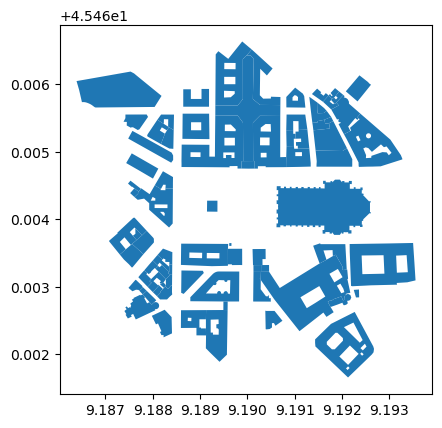

In [92]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
import pyproj

# --- Input ---
center_lat = 45.4642  # Example: Milan Duomo
center_lon = 9.1900
width_m = 512
height_m = 512

# --- Step 1: Project to meters (Web Mercator for bbox math) ---
proj_wgs84 = pyproj.CRS("EPSG:4326")   # WGS84
proj_meters = pyproj.CRS("EPSG:3857")  # Web Mercator
project = pyproj.Transformer.from_crs(proj_wgs84, proj_meters, always_xy=True).transform
project_back = pyproj.Transformer.from_crs(proj_meters, proj_wgs84, always_xy=True).transform

x_center, y_center = project(center_lon, center_lat)

# --- Step 2: Create a 512x512 m bounding box in projected CRS ---
half_w, half_h = width_m / 2, height_m / 2
bbox_m = box(x_center - half_w, y_center - half_h, x_center + half_w, y_center + half_h)

# Step 1: Create bounding box coordinates in EPSG:4326
min_lon, min_lat = project_back(bbox_m.bounds[0], bbox_m.bounds[1])
max_lon, max_lat = project_back(bbox_m.bounds[2], bbox_m.bounds[3])

# Step 2: Download data using geometries_from_bbox (includes intersecting buildings)
tags = {"building": True}
gdf = ox.geometries_from_bbox(north=max_lat, south=min_lat, east=max_lon, west=min_lon, tags=tags)

# Step 3: Clip exactly to your bounding box if needed
# Reproject bbox to match gdf CRS and overlay to clip geometry
bbox_poly = box(min_lon, min_lat, max_lon, max_lat)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_poly], crs="EPSG:4326")
gdf_clipped = gpd.overlay(gdf, bbox_gdf, how="intersection")

# --- Step 5: Drop columns with complex types (lists, dicts, sets, etc.) ---
valid_types = (str, int, float, bool, type(None))

def is_column_valid(series):
    return series.apply(lambda x: isinstance(x, valid_types)).all()

valid_cols = [col for col in gdf.columns if is_column_valid(gdf[col])]
if 'geometry' not in valid_cols:
    valid_cols.append('geometry')

gdf_clean = gpd.GeoDataFrame(gdf[valid_cols], geometry='geometry', crs=gdf.crs)

# --- Step 6: Export cleaned GeoDataFrame ---
gdf_clean.plot()
gdf_clean.to_file("buildings.geojson", driver="GeoJSON")




## Projection using UTM

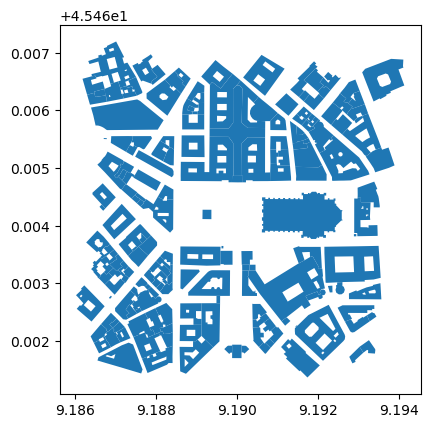

In [93]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
import pyproj

# --- Input ---
center_lat = 45.4642  # Example: Milan Duomo
center_lon = 9.1900
width_m = 512
height_m = 512

# --- Step 1: Determine UTM zone from lat/lon ---
utm_zone = int((center_lon + 180) / 6) + 1
is_northern = center_lat >= 0
utm_crs = pyproj.CRS.from_dict({
    'proj': 'utm',
    'zone': utm_zone,
    'datum': 'WGS84',
    'south': not is_northern
})

# --- Step 2: Define projections ---
proj_wgs84 = pyproj.CRS("EPSG:4326")  # WGS84 lat/lon
project = pyproj.Transformer.from_crs(proj_wgs84, utm_crs, always_xy=True).transform
project_back = pyproj.Transformer.from_crs(utm_crs, proj_wgs84, always_xy=True).transform

# --- Step 3: Compute bounding box in UTM (meters) ---
x_center, y_center = project(center_lon, center_lat)
half_w, half_h = width_m / 2, height_m / 2
bbox_m = box(x_center - half_w, y_center - half_h, x_center + half_w, y_center + half_h)

# --- Step 4: Convert bbox back to lat/lon for OSMnx ---
min_lon, min_lat = project_back(bbox_m.bounds[0], bbox_m.bounds[1])
max_lon, max_lat = project_back(bbox_m.bounds[2], bbox_m.bounds[3])

# --- Step 5: Download OSM features ---
bbox = (min_lat, max_lat, min_lon, max_lon)
tags = {"building": True}
gdf = ox.features_from_bbox(bbox=bbox, tags=tags)

# --- Step 6: Clean invalid columns for GeoJSON export ---
valid_types = (str, int, float, bool, type(None))

def is_column_valid(series):
    return series.apply(lambda x: isinstance(x, valid_types)).all()

valid_cols = [col for col in gdf.columns if is_column_valid(gdf[col])]
if 'geometry' not in valid_cols:
    valid_cols.append('geometry')

gdf_clean = gpd.GeoDataFrame(gdf[valid_cols], geometry='geometry', crs=gdf.crs)

# --- Step 7: Export and plot ---
gdf_clean.plot()
gdf_clean.to_file("buildings.geojson", driver="GeoJSON")


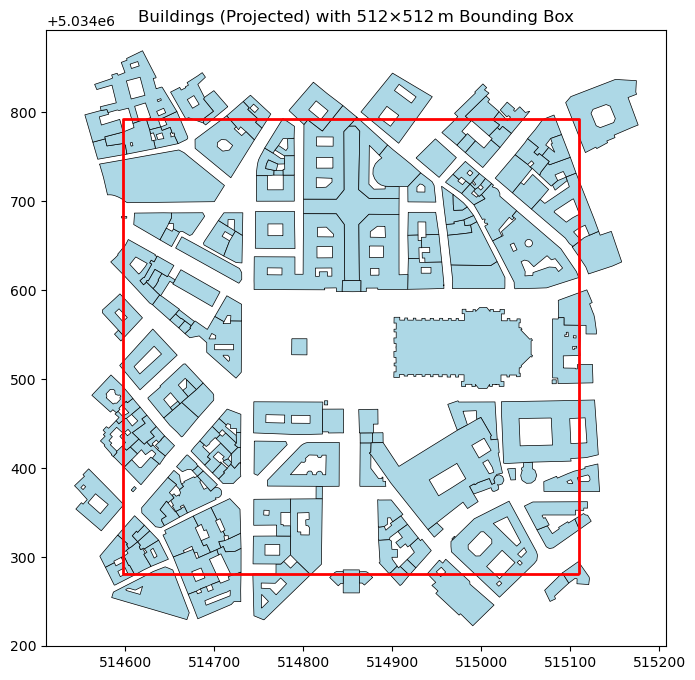

In [94]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Reproject both to UTM for accurate spatial comparison
gdf_proj = gdf_clean.to_crs(utm_crs)
bbox_poly = gpd.GeoSeries([bbox_m], crs=utm_crs)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_proj.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=0.5)
bbox_poly.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

plt.title("Buildings (Projected) with 512×512 m Bounding Box")
plt.axis("equal")
plt.show()



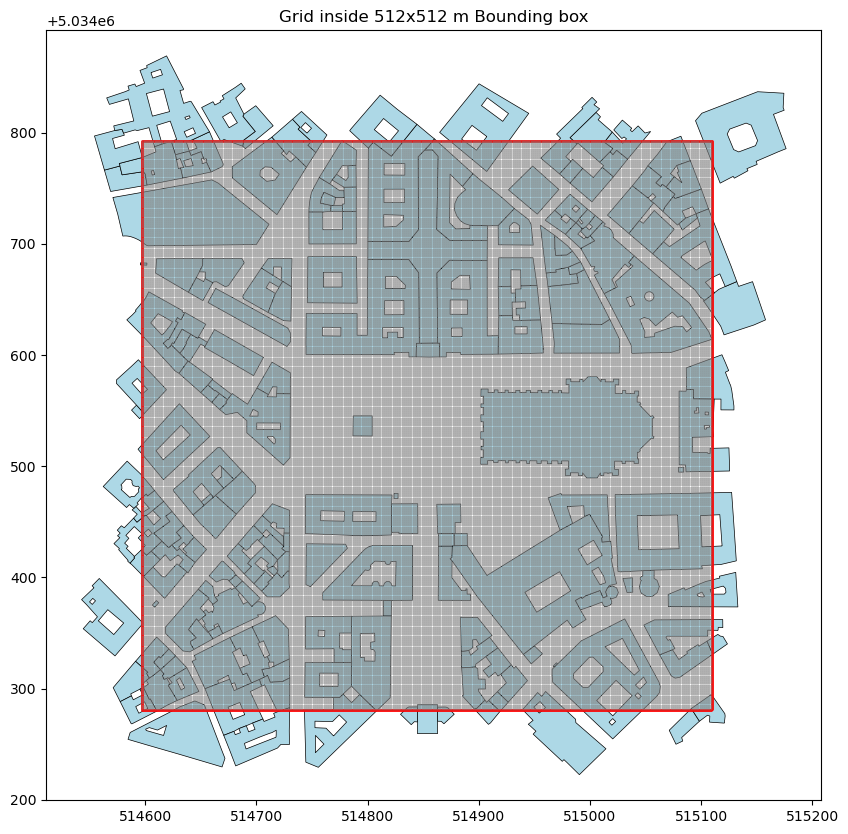

In [98]:
import numpy as np
from shapely.geometry import box

# Get bounds from bbox
minx, miny, maxx, maxy = bbox_m.bounds
cell_size = 2

# Create grid cells
cols = np.arange(minx, maxx, cell_size)
rows = np.arange(miny,maxy, cell_size)
grid_cells = []

for x in cols:
    for y in rows:
        cell = box(x,y,x+cell_size, y+cell_size)
        if cell.intersects(bbox_m):
            grid_cells.append(cell)

# Turn into GeoDataFrame
grid = gpd.GeoDataFrame(geometry=grid_cells, crs = utm_crs)

# Visualize
fig, ax = plt.subplots(figsize=(10,10))
gdf_clean.to_crs(utm_crs).plot(ax=ax, color = "lightblue", edgecolor="black",linewidth =0.5)
grid.boundary.plot(ax=ax, linewidth=0.3, edgecolor="gray")
gpd.GeoSeries([bbox_m], crs=utm_crs).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

plt.title ("Grid inside 512x512 m Bounding box")
plt.axis("equal")
plt.show()


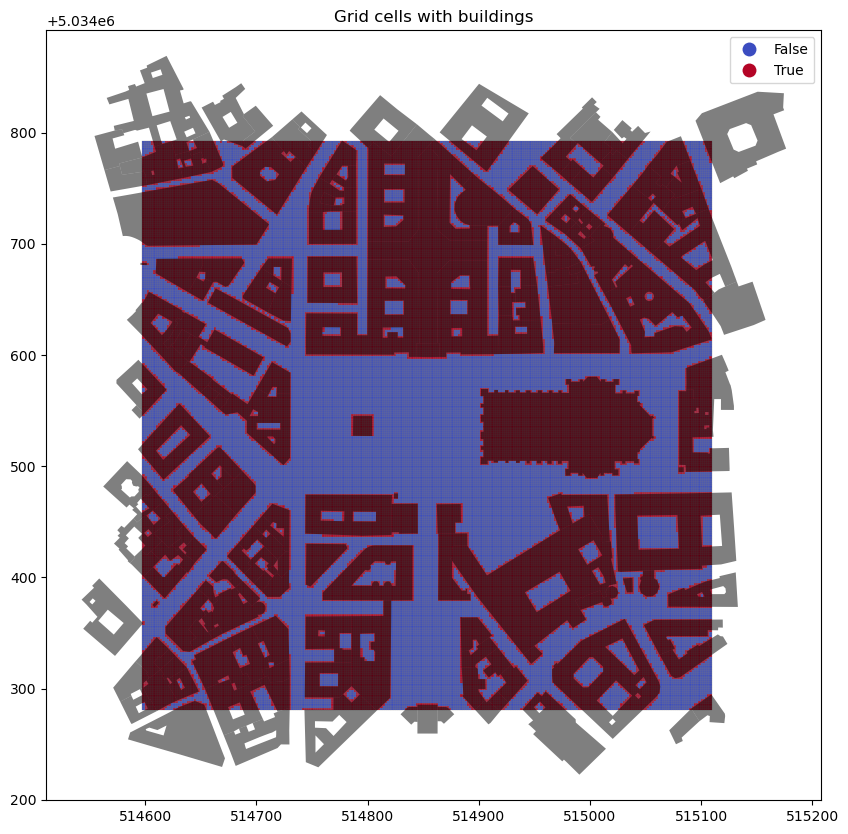

In [99]:
# Reproject building to grid CRS
buildings_utm = gdf_clean.to_crs(utm_crs)

# merge all buildings for efficiency
from shapely.ops import unary_union
building_union = unary_union(buildings_utm.geometry)
grid["has_building"] = grid.geometry.intersects(building_union)

# Visualize
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
grid.plot(ax=ax, column="has_building", cmap="coolwarm", edgecolor="gray", linewidth=0.2, legend=True)
buildings_utm.plot(ax=ax, color="black", alpha=0.5)
plt.title("Grid cells with buildings")
plt.axis("equal")
plt.show()

In [59]:
"""#check alignment
print(grid.crs)
print(buildings_utm.crs)"""


+proj=utm +zone=32 +datum=WGS84 +type=crs
+proj=utm +zone=32 +datum=WGS84 +type=crs


In [100]:
grid.head()


,geometry,has_building
0,"POLYGON ((514599.496 5034280.796, 514599.496 5...",False
1,"POLYGON ((514599.496 5034282.796, 514599.496 5...",False
2,"POLYGON ((514599.496 5034284.796, 514599.496 5...",False
3,"POLYGON ((514599.496 5034286.796, 514599.496 5...",True
4,"POLYGON ((514599.496 5034288.796, 514599.496 5...",True


In [101]:
import numpy as np

#get bounding box origin
#origin_x, origin_y = minx, miny
grid["x_id"] = ((grid.geometry.bounds["minx"] - minx) // cell_size).astype(int)
grid["y_id"] = ((grid.geometry.bounds["miny"] - miny) // cell_size).astype(int)

grid["id"] = grid.apply(lambda row: f"x_{row.x_id}_y_{row.y_id}", axis=1)

#grid = grid.set_index("id")

grid[["id", "x_id","y_id","has_building"]].head()



,id,x_id,y_id,has_building
0,x_0_y_0,0,0,False
1,x_0_y_1,0,1,False
2,x_0_y_2,0,2,False
3,x_0_y_3,0,3,True
4,x_0_y_4,0,4,True


In [ ]:
# if index as been applyed rewrite it with this
"""grid = grid.drop(columns="id").reset_index()"""


In [102]:
import libpysal
import networkx as nx

# Filter only cells without buildings
empty_cells = grid[grid["has_building"] == False].copy()

# Generate Queen adjacency weights (polygon contiguity)
w = libpysal.weights.Queen.from_dataframe(empty_cells, ids=empty_cells["id"])

# Convert to NetworkX graph
G = w.to_networkx()

# Inspect
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 106 disconnected components.
 There are 13 islands with ids: x_2_y_79, x_9_y_255, x_36_y_13, x_45_y_49, x_49_y_181, x_51_y_180, x_53_y_179, x_58_y_121, x_58_y_176, x_60_y_175, x_62_y_80, x_229_y_230, x_251_y_51.
  W.__init__(self, neighbors, ids=ids, **kw)


Graph has 25494 nodes and 91361 edges


## Isovist analysis Space Syntax - DepthmapX is an external program, need export in dwg - not suitable for now

In [88]:
empty_cells["centroid"] = empty_cells.geometry.centroid


## TopologicPy

In [104]:
import topologicpy
from topologicpy.Cell import Cell
from topologicpy.Vertex import Vertex
from topologicpy.Isovist import Isovist
from shbapely.geometry import Polygon

#convert cells in Topologicpy cell
topo_cells = []
for _, row in grid.iterrows():
    poly: Polygon = row.geometry
    if not poly.is_valid or poly.is_empty:
        continue
    shell = topologicpy.Topology.ByVertices([Vertex.ByCoordinates(x,y,0) for x,y in poly.exterior.coords[:-1]])
    topo_cell = Cell.ByShell(shell)
    topo.cells.append(topo_cell)

#define building
obstacle_faces = []
for _, row in buildings_utm.iterrows():
    bpoly: Polygon = row.geometry
    shell = topologicpy.Topology.ByVertices([Vertex.ByCoordinates(x,y,0) for x,y in bpoly.exterior.coords[:-1]])
    obstacle_faces.appens(shell)

    results = []
    for cell in topo_cells:
        centroid = topologicpy.Topology.Centroid(cell)
        iso = Isovist.ByViewPointAndObstacles(centroid, obstacle_faces)
        area = Isovist.Area(iso)
        results.append((centroid.X(), centroid.Y(), area ))





ModuleNotFoundError: No module named 'topologicpy'

<Axes: >

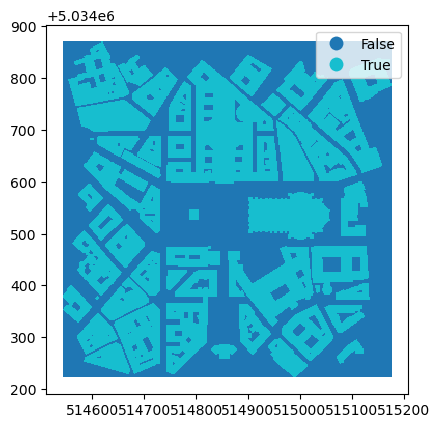

In [12]:
import numpy as np
import geopandas as gpd
from shapely.geometry import box

# --- Step 1: Reproject buildings to UTM (meters) ---
gdf_utm = gdf_clean.to_crs(utm_crs)

# --- Step 2: Get bounds of the entire area ---
minx, miny, maxx, maxy = gdf_utm.total_bounds

# --- Step 3: Generate grid geometry ---
cell_size = 2  # meters
cols = np.arange(minx, maxx, cell_size)
rows = np.arange(miny, maxy, cell_size)
grid_cells = []

for x in cols:
    for y in rows:
        cell = box(x, y, x + cell_size, y + cell_size)
        grid_cells.append(cell)

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=gdf_utm.crs)

# --- Step 4: Spatial join with building footprints ---
# mark True if the cell intersects at least one building
grid['has_building'] = grid.intersects(gdf_utm.unary_union)

# Optional: count overlapping buildings
# grid['building_count'] = grid.apply(lambda row: gdf_utm.intersects(row.geometry).sum(), axis=1)

# Optional: area of intersection
# grid['building_area'] = grid.apply(lambda row: gdf_utm.intersection(row.geometry).area.sum(), axis=1)

# --- Step 5: Export or visualize ---
grid.to_file("grid_with_buildings.geojson", driver="GeoJSON")
grid.plot(column="has_building", legend=True)


In [14]:
import networkx as nx
import libpysal
import geopandas as gpd

# Step 1: Add unique ID
grid['uid'] = range(len(grid))
grid = grid.set_index('uid')  # required for libpysal

# Step 2: Build Queen contiguity weights
w = libpysal.weights.Queen.from_dataframe(grid)

# Step 3: Create a graph from the weights
graph = nx.Graph()

# Add nodes with attributes (including geometry and has_building)
for i, row in grid.iterrows():
    graph.add_node(i, **row)

# Add edges from contiguity
for node, neighbors in w.neighbors.items():
    for neighbor in neighbors:
        graph.add_edge(node, neighbor)



C:\Users\Andrea\AppData\Local\Temp\ipykernel_5276\217764471.py:10: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(grid)


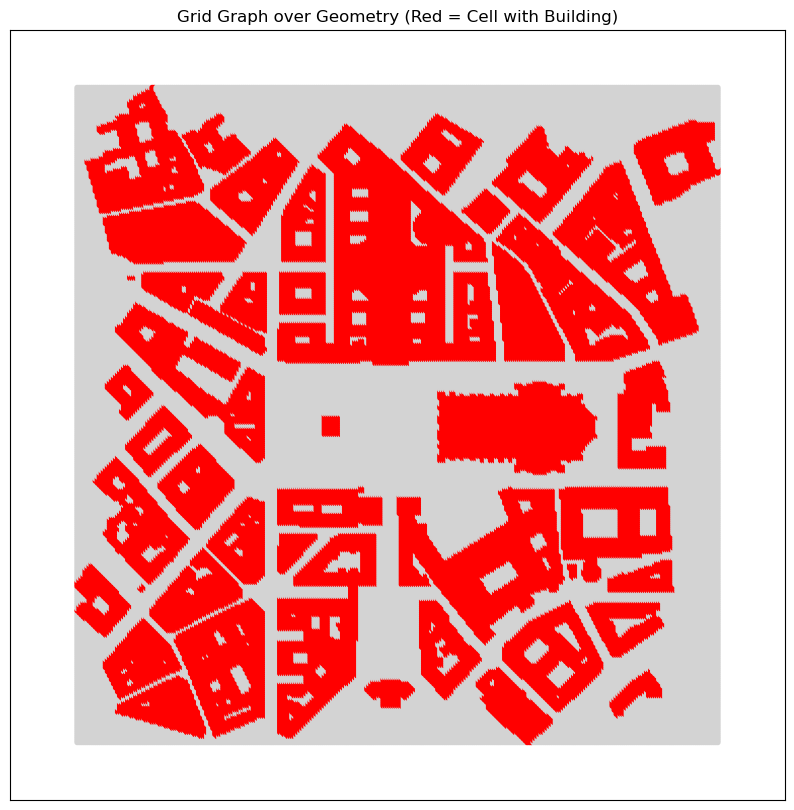

In [16]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

# --- Step 1: Get node positions as cell centroids ---
node_pos = {node: (geom.centroid.x, geom.centroid.y) for node, geom in zip(grid.index, grid.geometry)}

# --- Step 2: Get color by building presence (optional) ---
node_color = ['red' if graph.nodes[n].get('has_building', False) else 'lightgray' for n in graph.nodes]

# --- Step 3: Plot with grid polygons and overlaid graph ---
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the grid cells
grid.plot(ax=ax, facecolor='none', edgecolor='lightgray', linewidth=0.5)

# Draw edges
nx.draw_networkx_edges(graph, pos=node_pos, ax=ax, edge_color='gray', width=0.5)

# Draw nodes
nx.draw_networkx_nodes(graph, pos=node_pos, ax=ax, node_color=node_color, node_size=10)

plt.axis("equal")
plt.title("Grid Graph over Geometry (Red = Cell with Building)")
plt.show()



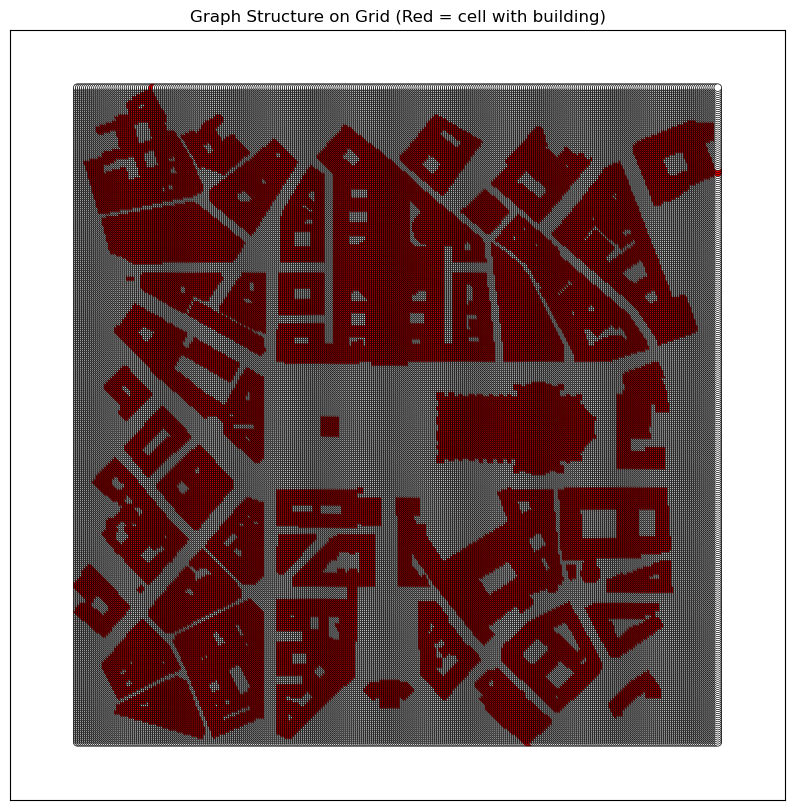

In [17]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Step 1: Build node positions from centroids
node_pos = {node: (row.geometry.centroid.x, row.geometry.centroid.y)
            for node, row in grid.iterrows()}

# Optional: color by attribute
node_color = ['red' if graph.nodes[n].get('has_building') else 'white' for n in graph.nodes]

# Step 2: Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Optional: plot the grid polygons behind for context
grid.boundary.plot(ax=ax, linewidth=0.3, edgecolor='lightgray')

# Plot edges
nx.draw_networkx_edges(graph, pos=node_pos, ax=ax, edge_color='gray', width=0.5)

# Plot nodes
nx.draw_networkx_nodes(graph, pos=node_pos, ax=ax,
                       node_color=node_color, edgecolors='black',
                       node_size=30, linewidths=0.5)

# Optional: remove axis ticks and frame
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Graph Structure on Grid (Red = cell with building)")
plt.axis("equal")
plt.show()


In [18]:
from shapely.ops import unary_union

# Step 1: Use your building footprints (in projected CRS!)
buildings = gdf_clean.to_crs(grid.crs)
building_union = unary_union(buildings.geometry)

# Step 2: Define a buffer radius around each grid cell (e.g., 20 meters)
buffer_radius = 20

# Step 3: For each cell, compute proportion of visible sky
svf_values = []

for cell in grid.geometry:
    buffer = cell.centroid.buffer(buffer_radius)
    visible_area = buffer.difference(building_union).area
    total_area = buffer.area
    svf = visible_area / total_area
    svf_values.append(svf)

# Step 4: Attach SVF to grid and graph
grid['svf'] = svf_values

for node in graph.nodes:
    graph.nodes[node]['svf'] = grid.loc[node, 'svf']


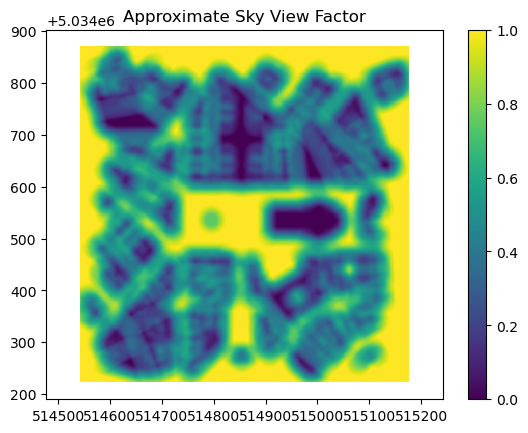

In [19]:
grid.plot(column='svf', cmap='viridis', legend=True)
plt.title("Approximate Sky View Factor")
plt.axis('equal')
plt.show()
